In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
conv_base = VGG19 (weights= 'imagenet',
                   include_top= False,
                   input_shape= (150,150,3))

conv_base.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________

In [3]:
"""This is Feature extraction without DATA AUGMENTATION,
    since with DATA AUGMENTATION it is much slower and more expensive and intractable on CPU.
"""
base_dir = r'C:\Users\Ceeva\Desktop\Github\ComputerVision-DL\cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# Function to extract the features after the block5
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150, 150),
                                            batch_size=batch_size, class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

# The features of (4, 4, 512) are extracted and then used as the input for the last Dense layer
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 20000 images belonging to 2 classes.

Found 3000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

# Now we take the extracted features and feed into the Dense layer
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, 
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6255 - val_loss: 0.4897 - val_acc: 0.7950
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4910 - acc: 0.7730 - val_loss: 0.4191 - val_acc: 0.8170
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4273 - acc: 0.8045 - val_loss: 0.3889 - val_acc: 0.8200
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3831 - acc: 0.8330 - val_loss: 0.3629 - val_acc: 0.8400
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3611 - acc: 0.8405 - val_loss: 0.3480 - val_acc: 0.8420
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3267 - acc: 0.8605 - val_loss: 0.3350 - val_acc: 0.8410
Epoch 7/30
2000/2000 [==============================] 

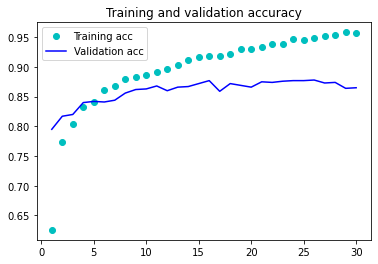

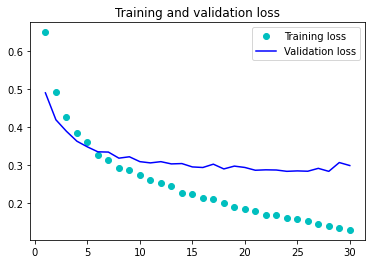

In [5]:
# Plotting the metrics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'co', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()